In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
import pickle
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nba_defs import draw_court

In [680]:
# import data
url = 'https://raw.githubusercontent.com/rich-thai/Streamlit-on-Heroku/master/data.csv'
df = pd.read_csv(url, index_col=0).reset_index()
action_count = df['action_type'].value_counts()
df['action'] = df.apply(lambda x: x['action_type'] if action_count[x['action_type']]>20 else x['combined_shot_type'], axis=1)
df = df[df['shot_made_flag'].notnull()]
df['loc_sq'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)
X_train_made = df[df['shot_made_flag']==1][['loc_x','loc_y','loc_sq']]
X_train = df[['loc_x','loc_y','loc_sq']]
y_train = df[['shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range']]
y_train_made = df[df['shot_made_flag']==1][['action']]
const = 10.53425466162496

In [681]:
y_train.nunique()

shot_type          2
shot_zone_area     6
shot_zone_basic    7
shot_zone_range    5
dtype: int64

In [682]:
y_train

,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range
1,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.
2,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.
3,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.
4,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.
5,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.
...,...,...,...,...
30691,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.
30692,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.
30694,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.
30695,3PT Field Goal,Center(C),Above the Break 3,24+ ft.


In [683]:
encoder = OrdinalEncoder()
encoderMade = OrdinalEncoder()
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
y_train_transform = encoder.fit_transform(y_train)
y_train_made_transform = encoderMade.fit_transform(y_train_made)
X_train_scaled = scaler.fit_transform(X_train)
X_train_made_scaled = scaler2.fit_transform(X_train_made)
pickle.dump(encoder, open('encoder.pkl', 'wb'))
pickle.dump(encoderMade, open('encoderMade.pkl', 'wb'))
pickle.dump(scaler, open('loc_scaler.pkl', 'wb'))
pickle.dump(scaler2, open('loc_scaler2.pkl', 'wb'))

X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_train_transform, test_size=0.2, random_state=42)
X_train_made, X_valid_made, y_train_made, y_valid_made = train_test_split(X_train_made_scaled, y_train_made_transform, test_size=0.2, random_state=42)

In [555]:
X_train_scaled

array([[0.18674699, 0.05269461, 0.19827769],
       [0.29919679, 0.21437126, 0.21292765],
       [0.77911647, 0.26227545, 0.28146014],
       ...,
       [0.23293173, 0.25149701, 0.26942454],
       [0.56425703, 0.37245509, 0.33946353],
       [0.50401606, 0.13892216, 0.09093867]])

In [647]:
pointValueModel = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dense(2, activation="softmax")
])
pointValueModel.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
pointValueModel.fit(X_train, y_train[:,0], epochs=50
                    ,validation_data=(X_valid, y_valid[:,0])
                    ,verbose=False
                   )

In [648]:
pointValueModel.save('pointValueModel')

INFO:tensorflow:Assets written to: pointValueModel\assets


In [649]:
zoneAreaModel = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dense(6, activation="softmax")
])
zoneAreaModel.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
zoneAreaModel.fit(X_train, y_train[:,1], epochs=50
                  ,validation_data=(X_valid, y_valid[:,1])
                  ,verbose=False
                 )

In [650]:
zoneAreaModel.save('zoneAreaModel')

INFO:tensorflow:Assets written to: zoneAreaModel\assets


In [651]:
zoneBasicModel = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),    
    keras.layers.Dense(7, activation="softmax")
])
zoneBasicModel.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
zoneBasicModel.fit(X_train, y_train[:,2], epochs=50
                   ,validation_data=(X_valid, y_valid[:,2])
                  ,verbose=False)

In [652]:
zoneBasicModel.save('zoneBasicModel')

INFO:tensorflow:Assets written to: zoneBasicModel\assets


In [653]:
zoneRangeModel = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(50, activation="relu"),    
    keras.layers.Dense(5, activation="softmax")
])
zoneRangeModel.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
zoneRangeModel.fit(X_train, y_train[:,3], epochs=50
                   ,validation_data=(X_valid, y_valid[:,3])
                   ,verbose=False
                  )

In [654]:
zoneRangeModel.save('zoneRangeModel')

INFO:tensorflow:Assets written to: zoneRangeModel\assets


In [638]:
actionModel = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),    
    keras.layers.Dense(36, activation="softmax")
])
actionModel.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
actionModel.fit(X_train_made, y_train_made[:,0], epochs=50
                ,validation_data=(X_valid_made, y_valid_made[:,0])
               ,verbose=False
               )

In [655]:
actionModel.save('actionModel')

INFO:tensorflow:Assets written to: actionModel\assets


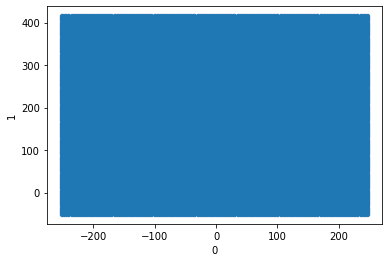

In [663]:
coord_df = pd.DataFrame([[i,j] for i in range(-250,250,5) for j in range(-50,420,5)])
coord_df.plot.scatter(x=0,y=1)

In [664]:
coord_df[2] = np.sqrt(coord_df[0]**2 + coord_df[1]**2)

In [665]:
coord_df

,0,1,2
0,-250,-50,254.950976
1,-250,-45,254.017716
2,-250,-40,253.179778
3,-250,-35,252.438111
4,-250,-30,251.793566
...,...,...,...
9395,245,395,464.811790
9396,245,400,469.068225
9397,245,405,473.339202
9398,245,410,477.624329


In [666]:
pointValueModel.predict_classes(coord_df[[0,1,2]].values)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [667]:
coord_df['shot_type_est'] = pointValueModel.predict_classes(scaler.transform(coord_df[[0,1,2]].values))
coord_df['zone_area_est'] = zoneAreaModel.predict_classes(scaler.transform(coord_df[[0,1,2]].values))
coord_df['zone_basic_est'] = zoneBasicModel.predict_classes(scaler.transform(coord_df[[0,1,2]].values))
coord_df['zone_range_est'] = zoneRangeModel.predict_classes(scaler.transform(coord_df[[0,1,2]].values))
coord_df['action_est'] = actionModel.predict_classes(scaler2.transform(coord_df[[0,1,2]].values))

In [668]:
coord_df = pd.concat([coord_df[[0,1,2]]
                      ,pd.DataFrame(encoder.inverse_transform(coord_df[['shot_type_est','zone_area_est','zone_basic_est','zone_range_est']]), 
                                    columns=['shot_type_est','zone_area_est','zone_basic_est','zone_range_est'])
                     ,pd.DataFrame(encoderMade.inverse_transform(coord_df['action_est'].values.reshape(-1,1)),columns=['action_est'])
                     ], axis=1)

In [669]:
coord_df.head()

,0,1,2,shot_type_est,zone_area_est,zone_basic_est,zone_range_est,action_est
0,-250,-50,254.950976,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Jump Shot
1,-250,-45,254.017716,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Jump Shot
2,-250,-40,253.179778,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Jump Shot
3,-250,-35,252.438111,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Jump Shot
4,-250,-30,251.793566,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Jump Shot


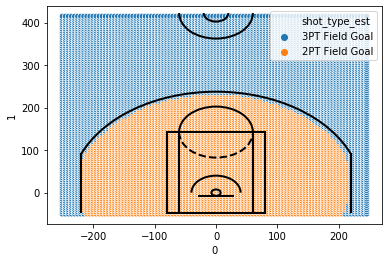

In [670]:
sns.scatterplot(data=coord_df, x=0, y=1, hue='shot_type_est')
draw_court()

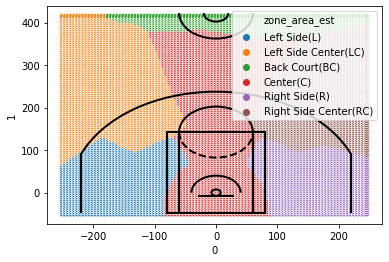

In [671]:
sns.scatterplot(data=coord_df, x=0, y=1, hue='zone_area_est')
draw_court()

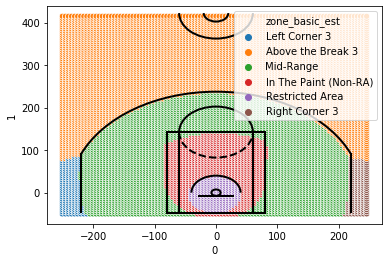

In [672]:
sns.scatterplot(data=coord_df, x=0, y=1, hue='zone_basic_est')
draw_court()

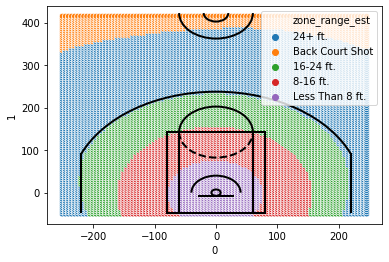

In [673]:
sns.scatterplot(data=coord_df, x=0, y=1, hue='zone_range_est')
draw_court()

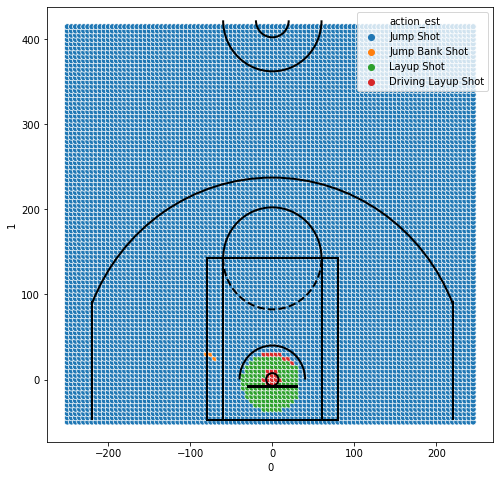

In [674]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=coord_df, x=0, y=1, hue='action_est')
draw_court()